# Signal Modulation classification 3
Experiment with architecture and data

**References**:
- [Original SIM2](https://www.mathworks.com/help/deeplearning/ug/modulation-classification-with-deep-learning.html)
- [Convolutional Radio Modulation Recognition Networks](https://arxiv.org/pdf/1602.04105.pdf)
- [Automatic Signal Modulation Recognition based on Deep Convolutional Neural Network](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwi8gNXSl5b9AhWn-yoKHRtdCGUQFnoECBIQAQ&url=https%3A%2F%2Fwww.atlantis-press.com%2Farticle%2F125913178.pdf&usg=AOvVaw1NhM3rX7_Ve6yQoFJlmecP)

## Imports

In [1]:
# imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import random
import os
import sys
import importlib

from pathlib import Path
import glob
import time
from scipy import io
from typing import Tuple

sys.path.append("..") # not good
from tools.data import load_data_radioml_v1

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
# config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

def reload_module(m: str):
    imported_module = importlib.import_module(m)
    importlib.reload(imported_module)


## Data loading for model training/evaluation/training

Please refer to ../generate_data.py to generate data

All confiuguration should be in the cell below

In [4]:
# modulations = [
#     "16QAM",
#     "64QAM",
#     "8PSK",
#     "B-FM",
#     "BPSK",
#     "CPFSK",
#     "DSB-AM",
#     "GFSK",
#     "PAM4",
#     "QPSK",
#     "SSB-AM",
# ]

# N_CLASSES = len(modulations)
MODEL_DATA_TYPE = np.float32
N_SAMPLES = 1024


SEED = 123456
set_seed(SEED)

# Training
train_model = True
N_EPOCHS = 12
BATCH_SIZE = 128
# TRAIN_DATA_DIR = "../data/train_data_SIMC1_SNR_10"
# TRAIN_DATA_DIR = "/development/download/train_data_SIMC1_SNR_30_10k/"
# TRAIN_DATA_DIR = "/development/download/train_data_SIMC1_SNR_mixed_0-30_30k/"
# TRAIN_DATA_DIR = "/development/download/train_data_SIMC1_SNR_mixed_0-30_30k"
TRAIN_DATA_DIR = "../data/RML2016.10a/RML2016.10a_dict.pkl"

# Deployment
model_name = "simc_2_radioml_v1_data"
MODELS_DIR = f'models_{model_name}_RADIOML_V1_DATA/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'


Explore dataset used in Convolutional Radio Modulation Recognition Networks

In [5]:
reload_module("tools.data")
from tools.data import load_data_radioml_v1
labels, data, modulations = load_data_radioml_v1(TRAIN_DATA_DIR, to_1024=False, transpose=False)

In [6]:
print(modulations)
print(labels.shape)
print(data.shape)
# crmrn_ds_keys = list(crmrn_ds.keys())
# print(crmrn_ds_keys)
# print(len(crmrn_ds.keys())) # 20 (snr -20 to 20 with step 2) * 11
# for key in crmrn_ds:
#     print(len(crmrn_ds[key]), end=", ")
# print()
# print(crmrn_ds[list(crmrn_ds.keys())[0]].shape)

['WBFM', 'GFSK', 'QPSK', 'QAM16', 'AM-SSB', 'QAM64', 'PAM4', 'BPSK', 'CPFSK', '8PSK', 'AM-DSB']
(220000,)
(220000, 1, 2, 128)


### Data preprocessing

In [7]:
# classes = list(set(map(lambda v: v[0].decode("utf-8"), crmrn_ds_keys)))
# print(classes)
# print(len(classes))
# class_name_to_class_idx = {name: idx for idx, name in enumerate(classes)}
# print(class_name_to_class_idx)

In [8]:
# ds_size = 220 * 1000 // 8
# data = np.empty((ds_size, 1, 1024, 2))
# labels = np.empty((ds_size,), dtype=np.uint8)


# cur_idx = 0
# for (class_name, snr), raw_data in crmrn_ds.items():
#     str_class_name = class_name.decode("utf-8")
#     for frame_idx in range(0, len(raw_data), 8):
#         frame_1024 = np.hstack([raw_data[idx] for idx in range(frame_idx, frame_idx+8)])
#         data[cur_idx] = frame_1024.reshape((1, 1024, 2))
#         labels[cur_idx] = class_name_to_class_idx[str_class_name]
#         cur_idx += 1
    

In [9]:
# print(len(data))
# print(len(labels))
# print(data.shape)
# test_idx = 126
# print(data[test_idx].shape)
# print(data[test_idx])
# print(labels[test_idx])


There are 27_500 samples of size 1024x2 (complex numbers) for each of 11 modulations

In [10]:
DS_SIZE = len(labels)

n_train = int(0.8 * DS_SIZE)
n_validation = int(0.1 * DS_SIZE)
n_test = DS_SIZE - n_train - n_validation

random_indecies = np.arange(DS_SIZE)
np.random.shuffle(random_indecies)

train_indecies, validation_indecies, test_indecies, _ = np.split(
    random_indecies, [int(DS_SIZE * 0.8), int(DS_SIZE * 0.9), DS_SIZE]
)


In [11]:
train_data, train_labels = data[train_indecies], labels[train_indecies]
validation_data, validation_labels = data[validation_indecies], labels[validation_indecies]
test_data, test_labels = data[test_indecies], labels[test_indecies]

In [12]:
# Should save some memory
del data
del labels

## Model creation


In [13]:
# https://github.com/dksakkos/BatchNorm
class CustomBatchNorm(layers.Layer):
    def __init__(self, *args, **kwargs):
        super(CustomBatchNorm, self).__init__(*args, **kwargs)

    def build(self, input_shape):
        self.beta = self.add_weight(
            name="custom_batch_beta",
            shape=(input_shape[-1]),
            initializer="zeros",
            trainable=True,
        )

        self.gamma = self.add_weight(
            name="custom_batch_gamma",
            shape=(input_shape[-1]),
            initializer="ones",
            trainable=True,
        )

        self.moving_mean = self.add_weight(
            name="custom_batch_moving_mean",
            shape=(input_shape[-1]),
            initializer=tf.initializers.zeros,
            trainable=False,
        )

        self.moving_variance = self.add_weight(
            name="custom_batch_moving_variance",
            shape=(input_shape[-1]),
            initializer=tf.initializers.ones,
            trainable=False,
        )

    def get_moving_average(self, statistic, new_value):
        momentum = 0.9
        new_value = statistic * momentum + new_value * (1 - momentum)
        return statistic.assign(new_value)

    def normalise(self, x, x_mean, x_var):
        return (x - x_mean) / tf.sqrt(x_var + 1e-6)

    def call(self, inputs, training):
        if training:
            assert len(inputs.shape) in (2, 4)
            if len(inputs.shape) > 2:
                axes = [0, 1, 2]
            else:
                axes = [0]
            mean, var = tf.nn.moments(inputs, axes=axes, keepdims=False)
            self.moving_mean.assign(self.get_moving_average(self.moving_mean, mean))
            self.moving_variance.assign(self.get_moving_average(self.moving_variance, var))
        else:
            mean, var = self.moving_mean, self.moving_variance
        x = self.normalise(inputs, mean, var)
        return self.gamma * x + self.beta


def create_model_simc_2():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(16, (1, 8), padding="same", name="CNN1_")(InputLayer)
    # N1 = layers.LayerNormalization()
    BN1 = CustomBatchNorm(name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)

    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)
    CNN2 = layers.Conv2D(24, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = CustomBatchNorm(name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)

    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)
    CNN3 = layers.Conv2D(32, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = CustomBatchNorm(name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)

    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)
    CNN4 = layers.Conv2D(48, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = CustomBatchNorm(name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)

    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)
    CNN5 = layers.Conv2D(64, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = CustomBatchNorm(name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)

    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)
    CNN6 = layers.Conv2D(96, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = CustomBatchNorm(name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    # FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Flatten(name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)

    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model


def create_model_original():
    InputLayer = keras.Input(shape=(1, 1024, 2))
    CNN1 = layers.Conv2D(16, (1, 8), padding="same", name="CNN1_")(InputLayer)
    BN1 = layers.BatchNormalization(epsilon=0.000010, name="BN1_")(CNN1)
    ReLU1 = layers.ReLU()(BN1)
    MaxPool1 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU1)

    CNN2 = layers.Conv2D(24, (1, 8), padding="same", name="CNN2_")(MaxPool1)
    BN2 = layers.BatchNormalization(epsilon=0.000010, name="BN2_")(CNN2)
    ReLU2 = layers.ReLU()(BN2)
    MaxPool2 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU2)

    CNN3 = layers.Conv2D(32, (1, 8), padding="same", name="CNN3_")(MaxPool2)
    BN3 = layers.BatchNormalization(epsilon=0.000010, name="BN3_")(CNN3)
    ReLU3 = layers.ReLU()(BN3)
    MaxPool3 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU3)

    CNN4 = layers.Conv2D(48, (1, 8), padding="same", name="CNN4_")(MaxPool3)
    BN4 = layers.BatchNormalization(epsilon=0.000010, name="BN4_")(CNN4)
    ReLU4 = layers.ReLU()(BN4)
    MaxPool4 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU4)

    CNN5 = layers.Conv2D(64, (1, 8), padding="same", name="CNN5_")(MaxPool4)
    BN5 = layers.BatchNormalization(epsilon=0.000010, name="BN5_")(CNN5)
    ReLU5 = layers.ReLU()(BN5)
    MaxPool5 = layers.MaxPool2D(pool_size=(1, 2), strides=(1, 2))(ReLU5)

    CNN6 = layers.Conv2D(96, (1, 8), padding="same", name="CNN6_")(MaxPool5)
    BN6 = layers.BatchNormalization(epsilon=0.000010, name="BN6_")(CNN6)
    ReLU6 = layers.ReLU()(BN6)

    AP1 = layers.AveragePooling2D(pool_size=(1, 32), strides=(1, 1))(ReLU6)
    FC1 = layers.Reshape((1, 1, -1), name="FC1_preFlatten1")(AP1)
    FC1 = layers.Dense(11, name="FC1_")(FC1)

    SoftMax = layers.Softmax()(FC1)
    Output = layers.Flatten()(SoftMax)
    model = keras.Model(inputs=[InputLayer], outputs=[Output])
    return model

def create_model_radioml_cnn2():
    # in_shp = [2, 128]
    dr = 0.5 # dropout rate (%) 卷积层部分  https://keras-cn.readthedocs.io/en/latest/layers/convolutional_layer/#conv2d
    model = keras.models.Sequential() #这里使用keras的序贯模型  https://keras-cn.readthedocs.io/en/latest/models/sequential/
    model.add(keras.layers.Reshape((2, 1, 128), input_shape=(1, 2, 128)))
    # model.add(keras.layers.Input(shape=(1, 2, 128)))
    model.add(keras.layers.ZeroPadding2D((0, 2)))
    model.add(keras.layers.Conv2D(256, (1, 3),padding='valid', activation="relu", name="conv1",data_format="channels_first"))
    model.add(keras.layers.Dropout(dr))
    model.add(keras.layers.ZeroPadding2D((0, 2)))
    model.add(keras.layers.Conv2D(80, (2, 3), padding="valid", activation="relu", name="conv2",data_format="channels_first"))
    model.add(keras.layers.Dropout(dr))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
    model.add(keras.layers.Dropout(dr))
    model.add(keras.layers.Dense( len(modulations), kernel_initializer='he_normal', name="dense2" ))
    model.add(keras.layers.Activation('softmax'))
    model.add(keras.layers.Reshape([len(modulations)]))
    return model


In [14]:
model = create_model_radioml_cnn2()
model.summary()

ResourceExhaustedError: {{function_node __wrapped__StatelessTruncatedNormalV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[79360,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:StatelessTruncatedNormalV2]

In [ ]:
print(train_data.shape)

(176000, 1, 2, 128)


In [ ]:
# https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/ 
# learning rate schedule
# def step_decay(epoch):
#     lrate = 0.02
#     factor = epoch // 9
#     lrate /= (10**factor)
#     return lrate

# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy",
    metrics=['accuracy'],
)



In [55]:
filepath = "convmodrecnets_CNN2_0.5.wts.h5" #所要保存的文件名字，h5格式，不用写路径，默认在程序执行的文件夹内
# N_EPOCHS = 16 
# BATCH_SIZE = 256
N_EPOCHS = 100
BATCH_SIZE = 256
if train_model:
    h = model.fit(
        train_data,
        train_labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(validation_data, validation_labels), 
        callbacks=[
            keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
        ]
    )
else:
    model = tf.keras.models.load_model(MODEL_TF)


Epoch 1/100


ValueError: in user code:

    File "/root/anaconda3/envs/cfu/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/root/anaconda3/envs/cfu/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/root/anaconda3/envs/cfu/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/root/anaconda3/envs/cfu/lib/python3.8/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/root/anaconda3/envs/cfu/lib/python3.8/site-packages/keras/engine/training.py", line 1082, in compute_loss
        return self.compiled_loss(
    File "/root/anaconda3/envs/cfu/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/root/anaconda3/envs/cfu/lib/python3.8/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/root/anaconda3/envs/cfu/lib/python3.8/site-packages/keras/losses.py", line 284, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/root/anaconda3/envs/cfu/lib/python3.8/site-packages/keras/losses.py", line 2004, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/root/anaconda3/envs/cfu/lib/python3.8/site-packages/keras/backend.py", line 5532, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 11) are incompatible


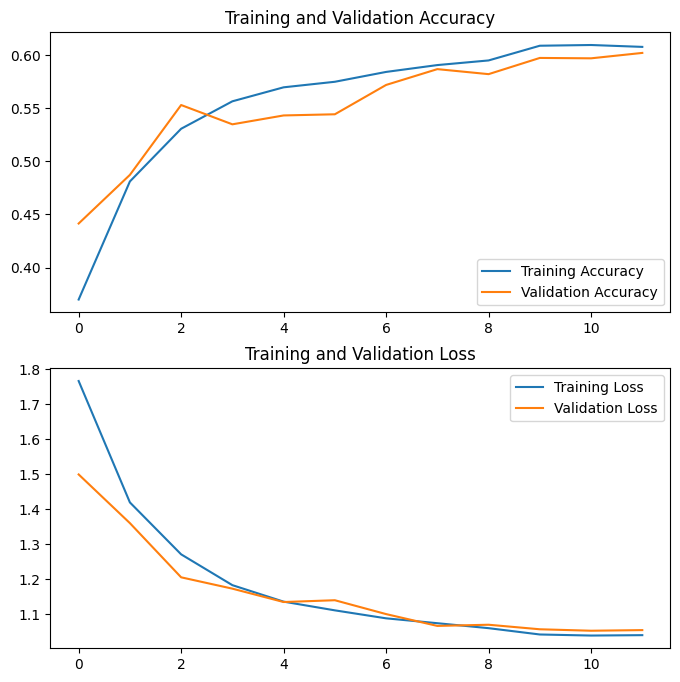

In [20]:
import matplotlib.pyplot as plt

acc = h.history['accuracy']
val_acc = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']

epochs_range = range(N_EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [21]:
test_preds = model.predict(test_data)

86/86 [==============================] - 0s 3ms/step


In [22]:
pred_labels = np.argmax(test_preds, axis=1)
print(pred_labels[0:10])
print(test_labels[0:10])

[0 6 1 4 0 8 0 4 1 1]
[8 0 1 4 8 8 0 4 5 2]


Overall test accuracy: 0.6003636363636363
AM-DSB test accuracy: 0.7235772357723578
AM-SSB test accuracy: 0.9135338345864662
BPSK test accuracy: 0.6374501992031872
8PSK test accuracy: 0.437984496124031
PAM4 test accuracy: 0.76
GFSK test accuracy: 0.7529411764705882
QPSK test accuracy: 0.44176706827309237
QAM16 test accuracy: 0.43333333333333335
WBFM test accuracy: 0.326271186440678
QAM64 test accuracy: 0.5057034220532319
CPFSK test accuracy: 0.6513409961685823


<Axes: >

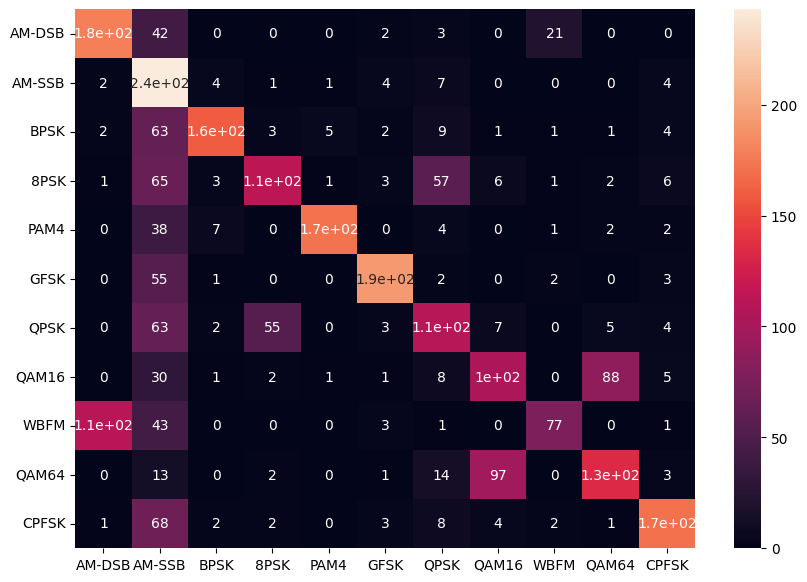

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels)}")
for ci, cl in enumerate(modulations):
    class_indecies = np.where(test_labels == ci)[0]
    cur_test_labels = test_labels[class_indecies]
    cur_pred_labels = pred_labels[class_indecies]
    print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")
cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels)
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(cm, index = modulations,
                  columns = modulations)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
raw_ds = load_data_radioml_v1(TRAIN_DATA_DIR)


### Mode deployment

In [19]:
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models_simc_2_SNR_30/model/assets


INFO:tensorflow:Assets written to: models_simc_2_SNR_30/model/assets


In [20]:
# reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite
model_no_quant_tflite = to_tf_lite(MODEL_TF)
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

396436

In [21]:
# reload_module("tools.deployment_tools")
# from tools.deployment_tools import deploy_model_tflite

# deploy_model_tflite(
#     model_no_quant_tflite,
#     # test_data.reshape((-1, 1, 1, 1024, 2)),
#     test_data,
#     test_labels, 
#     model_name=model_name,
#     classes=modulations,
#     create_cfu_playground_proj=True,
# )

## Quantization
Let's quantize model, and check accuracy

In [22]:
reload_module("tools.deployment_tools")
from tools.deployment_tools import to_tf_lite

representative_ds = train_data[:2000]
print(representative_ds.dtype)
print(representative_ds.shape)
model_tflite = to_tf_lite(MODEL_TF, representative_ds=representative_ds, apply_quantization=True)
open(MODEL_TFLITE, "wb").write(model_tflite)

float32
(2000, 1, 1024, 2)


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


114448

In [23]:
from tools.deployment_tools import predict_tflite

test_preds_quant = np.squeeze(predict_tflite(model_tflite, test_data))

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [24]:
pred_labels_quant = np.argmax(test_preds_quant, axis=1)
print(pred_labels_quant[:10])
print(test_labels[:10])

[2 8 3 2 0 1 2 7 7 4]
[9 8 3 9 0 0 2 7 7 4]


Overall test accuracy: 0.8470909090909091
16QAM test accuracy: 0.7524752475247525
64QAM test accuracy: 0.6149312377210217
8PSK test accuracy: 0.8263888888888888
B-FM test accuracy: 0.9889224572004028
BPSK test accuracy: 0.994692144373673
CPFSK test accuracy: 0.9968051118210862
DSB-AM test accuracy: 0.9408284023668639
GFSK test accuracy: 1.0
PAM4 test accuracy: 0.9841269841269841
QPSK test accuracy: 0.32146389713155293
SSB-AM test accuracy: 0.9206049149338374


<Axes: >

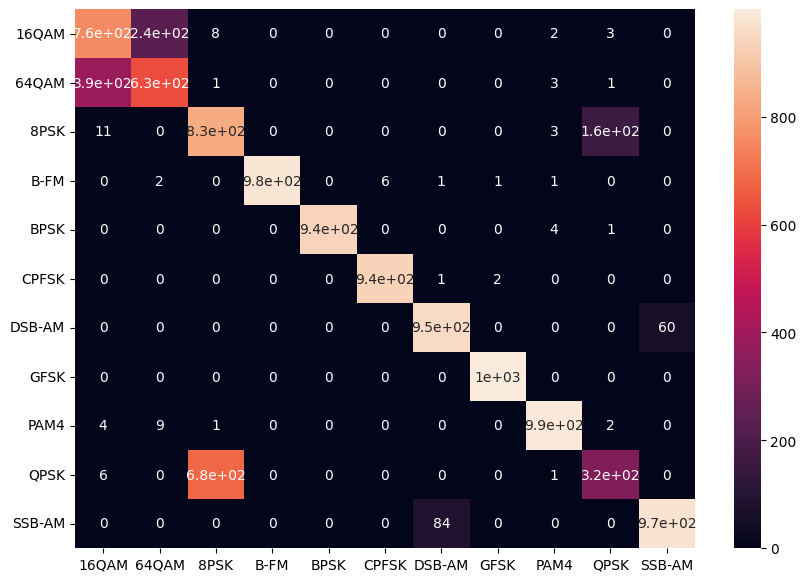

In [25]:
print(f"Overall test accuracy: {accuracy_score(test_labels, pred_labels_quant)}")
for ci, cl in enumerate(modulations):
    class_indecies = np.where(test_labels == ci)[0]
    cur_test_labels = test_labels[class_indecies]
    cur_pred_labels = pred_labels_quant[class_indecies]
    print(f"{cl} test accuracy: {accuracy_score(cur_test_labels, cur_pred_labels)}")

cm = confusion_matrix(y_true=test_labels, y_pred=pred_labels_quant)
df_cm = pd.DataFrame(cm, index = modulations,
                  columns = modulations)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [26]:
print(test_preds_quant.dtype)
print(test_preds_quant[0])

float32
[0.        0.        0.5703125 0.        0.        0.        0.
 0.        0.        0.4296875 0.       ]


In [34]:
reload_module("tools.deployment_tools")
from tools.deployment_tools import deploy_model_tflite

deploy_model_tflite(
    # model_no_quant_tflite,
    model_tflite,
    test_data,
    test_labels, 
    model_name=model_name,
    classes=modulations,
    create_cfu_playground_proj=True,
    epsilon=10,
    apply_quantization=True,
)

[debug] Export test data


11it [00:00, 677.24it/s]

[Warning] proj directory already exists: /development/RISC-V-SIMD-extension-for-the-AI-workload/proj/simc_2
